# The Indian 60/40 equity/bond portfolio

In [1]:
library(DBI)
library(plutoDbR)
library(plutoR)
library(tidyverse)
options("scipen"=999)
options(stringsAsFactors = FALSE)
source("/usr/share/pluto/config.R")
source("/usr/share/pluto/goofy/plot.common.R")
source("/usr/share/pluto/goofy/misc.common.R")

library(ggthemes)
library(quantmod)
library(PerformanceAnalytics)

options(repr.plot.width=16, repr.plot.height=8)

indices <- Indices()

In [2]:
# what are the begin and end dates that we have bond info for?

indices$IndiaGsecTimeSeries() %>%
    group_by(NAME) %>%
    summarize(ST = min(TIME_STAMP), ET = max(TIME_STAMP)) %>%
    print()

# Source:   lazy query [?? x 3]
# Database: NORWAY:StockViz:R
  NAME  ST         ET        
  <chr> <chr>      <chr>     
1 0_5   2003-12-31 2020-02-14
2 10_15 2003-12-31 2020-02-14
3 15_20 2003-12-31 2020-02-14
4 20_30 2003-12-31 2020-02-14
5 5_10  2003-12-31 2020-02-14


In [3]:
# what are the begin and end dates that we have equity index info for?

indicesOfInterest <- c('NIFTY 50 TR', 'NIFTY MIDCAP 100 TR', 'NIFTY MIDCAP 150 TR')

indices$NseTimeSeries() %>%
    filter(NAME %in% indicesOfInterest) %>%
    group_by(NAME) %>%
    summarize(ST = min(TIME_STAMP), ET = max(TIME_STAMP)) %>%
    print()

# Source:   lazy query [?? x 3]
# Database: NORWAY:StockViz:R
  NAME                ST         ET        
  <chr>               <chr>      <chr>     
1 NIFTY 50 TR         1999-06-30 2020-02-14
2 NIFTY MIDCAP 100 TR 2003-01-01 2020-02-14
3 NIFTY MIDCAP 150 TR 2005-04-01 2020-02-14


In [4]:
startDate <- as.Date('2004-01-01')
endDate <- as.Date('2019-11-30')

eqIndex1 <- "NIFTY 50 TR" 
eqIndex2 <- "NIFTY MIDCAP 100 TR" # maximum overlap is for MIDCAP 100 TR

bndIndex <- '0_5' #gsec. shortest tenure

eqDt1 <- indices$NseTimeSeries() %>%
    filter(NAME == eqIndex1 & TIME_STAMP >= startDate & TIME_STAMP <= endDate) %>%
    select(TIME_STAMP, CLOSE) %>%
    collect() %>%
    mutate(TIME_STAMP = as.Date(TIME_STAMP))

eqDt2 <- indices$NseTimeSeries() %>%
    filter(NAME == eqIndex2 & TIME_STAMP >= startDate & TIME_STAMP <= endDate) %>%
    select(TIME_STAMP, CLOSE) %>%
    collect() %>%
    mutate(TIME_STAMP = as.Date(TIME_STAMP))

bndDt <- indices$IndiaGsecTimeSeries() %>%
    filter(NAME == bndIndex & TIME_STAMP >= startDate & TIME_STAMP <= endDate) %>%
    select(TIME_STAMP, TRI) %>%
    collect() %>%
    mutate(TIME_STAMP = as.Date(TIME_STAMP))

eqXts1 <- Common.NormalizeMonthlyDates(monthlyReturn(xts(eqDt1$CLOSE, eqDt1$TIME_STAMP)))
eqXts2 <- Common.NormalizeMonthlyDates(monthlyReturn(xts(eqDt2$CLOSE, eqDt2$TIME_STAMP)))
bndXts <- Common.NormalizeMonthlyDates(monthlyReturn(xts(bndDt$TRI, bndDt$TIME_STAMP)))

port1 <- eqXts1*0.6 + bndXts*0.4
port2 <- eqXts2*0.6 + bndXts*0.4

eqAnnXts1 <- Common.NormalizeMonthlyDates(yearlyReturn(xts(eqDt1$CLOSE, eqDt1$TIME_STAMP)))
eqAnnXts2 <- Common.NormalizeMonthlyDates(yearlyReturn(xts(eqDt2$CLOSE, eqDt2$TIME_STAMP)))
bndAnnXts <- Common.NormalizeMonthlyDates(yearlyReturn(xts(bndDt$TRI, bndDt$TIME_STAMP)))

portAnn1 <- eqAnnXts1*0.6 + bndAnnXts*0.4
portAnn2 <- eqAnnXts2*0.6 + bndAnnXts*0.4

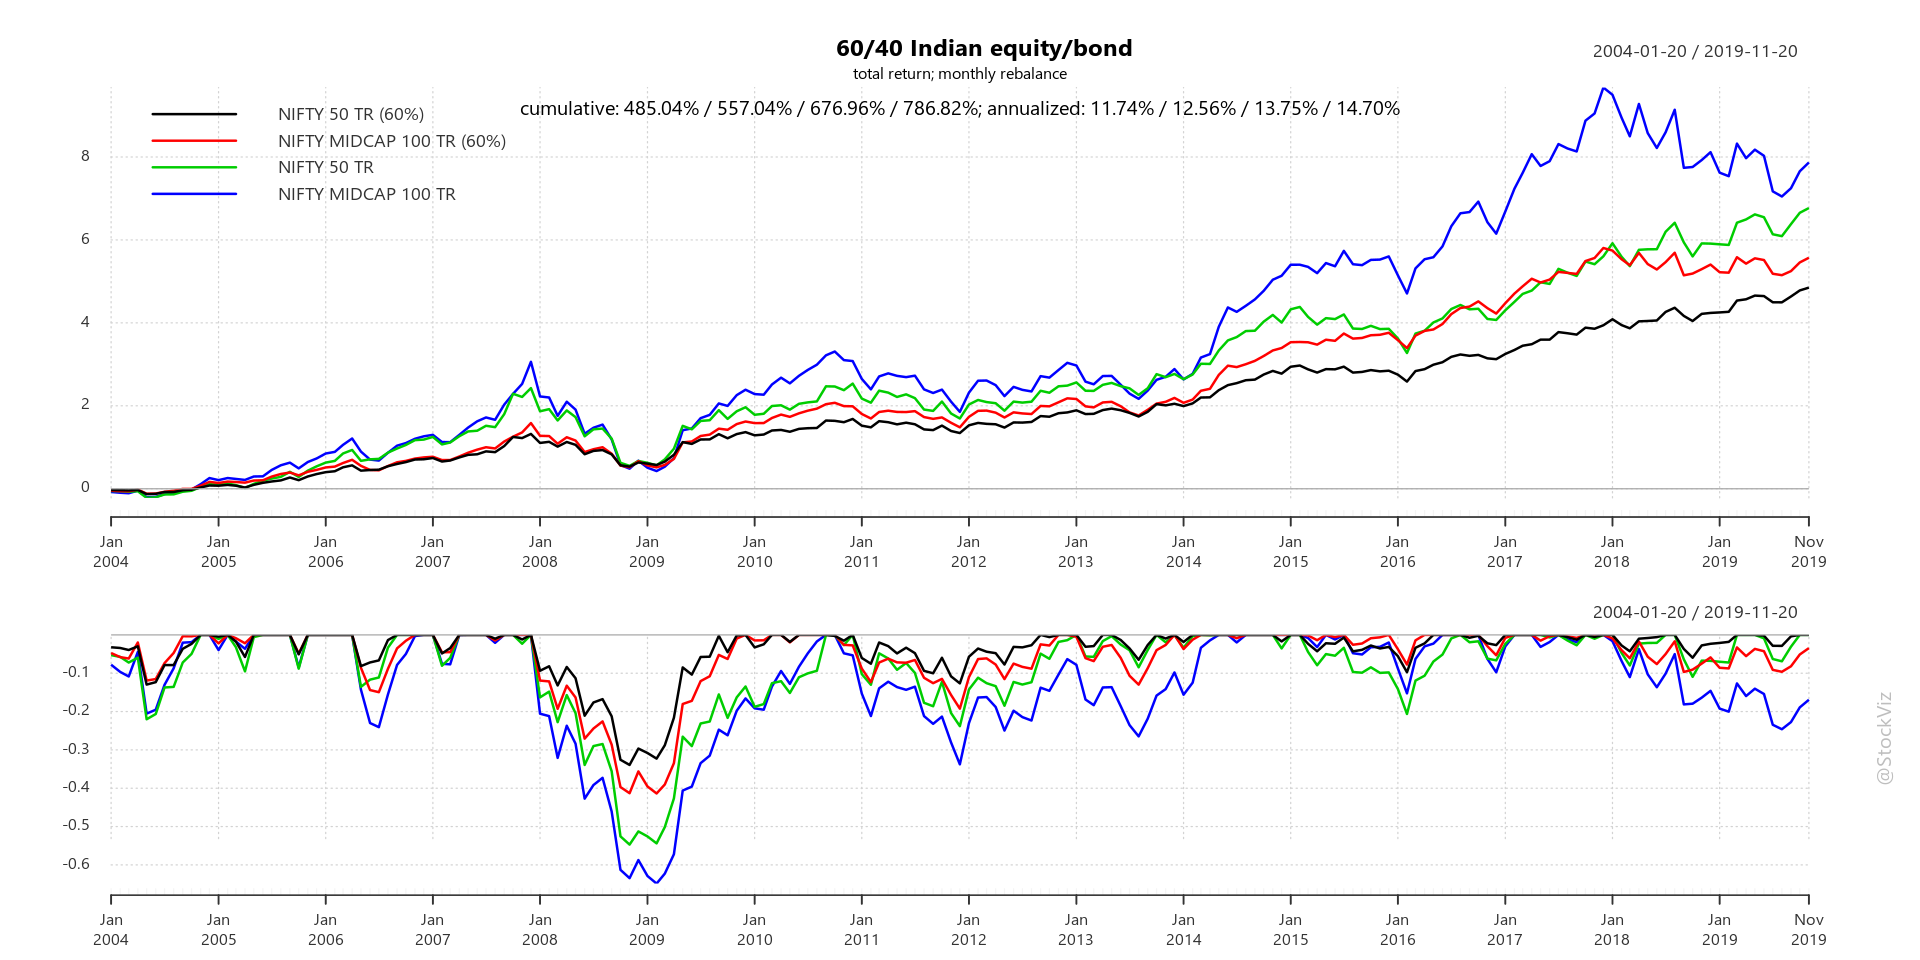

In [5]:
#plot the different scenarios
port2plot <- merge(port1, port2, eqXts1, eqXts2)
names(port2plot) <- c(sprintf("%s (60%%)", eqIndex1), sprintf("%s (60%%)", eqIndex2), eqIndex1, eqIndex2)
Common.PlotCumReturns(port2plot, "60/40 Indian equity/bond", "total return; monthly rebalance")

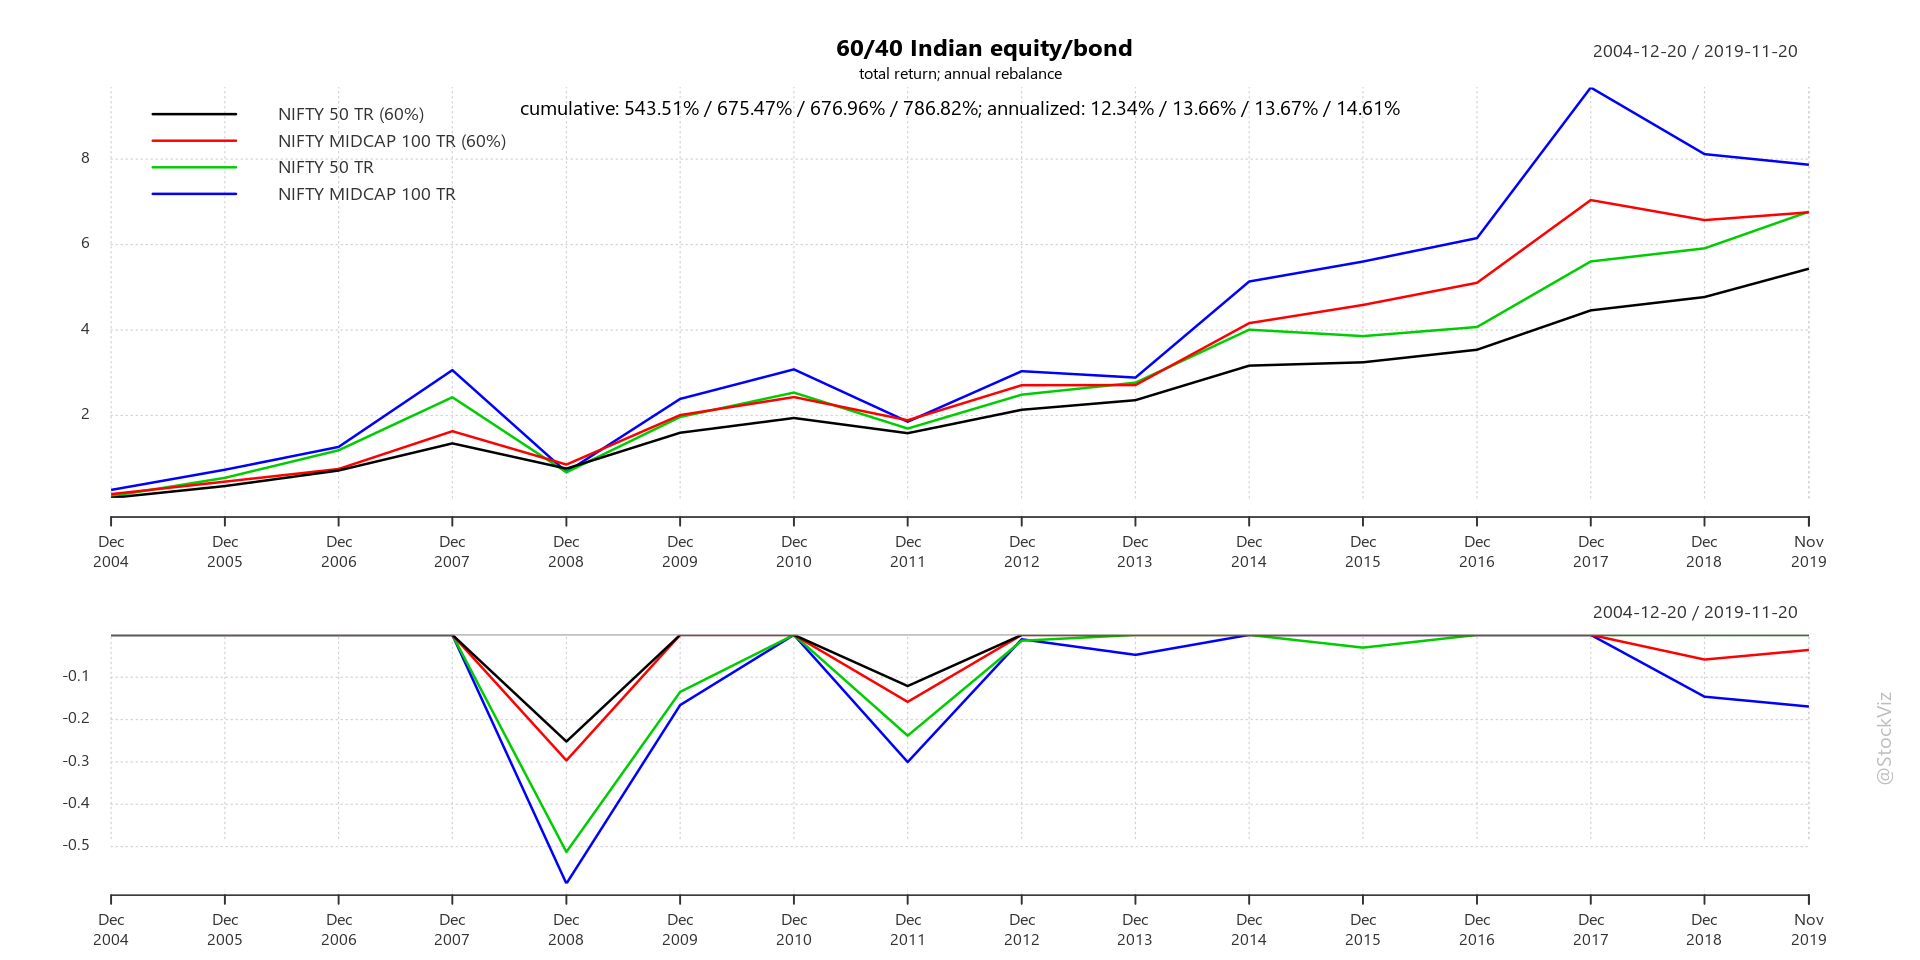

In [6]:
#plot the different scenarios
port2plot <- merge(portAnn1, portAnn2, eqAnnXts1, eqAnnXts2)
names(port2plot) <- c(sprintf("%s (60%%)", eqIndex1), sprintf("%s (60%%)", eqIndex2), eqIndex1, eqIndex2)
Common.PlotCumReturns(port2plot, "60/40 Indian equity/bond", "total return; annual rebalance")

## Tax impact
assume transaction costs are zero

In [7]:
bndTax <- 0.3
eqTax <- 0.1

In [25]:
eqXts1y <- Common.NormalizeMonthlyDates(to.yearly(xts(eqDt1$CLOSE, eqDt1$TIME_STAMP))[,4])
eqXts2y <- Common.NormalizeMonthlyDates(to.yearly(xts(eqDt2$CLOSE, eqDt2$TIME_STAMP))[,4])
bndXtsy <- Common.NormalizeMonthlyDates(to.yearly(xts(bndDt$TRI, bndDt$TIME_STAMP))[,4])

In [31]:
allXts <- na.omit(merge(eqXts1y, eqXts2y, bndXtsy))

In [32]:
allXts <- merge(allXts, (1-eqTax)*(as.numeric(allXts[, 1])/as.numeric(stats::lag(allXts[, 1]), -1) - 1))
allXts <- merge(allXts, (1-eqTax)*(as.numeric(allXts[, 2])/as.numeric(stats::lag(allXts[, 2]), -1) - 1))
allXts <- merge(allXts, (1-bndTax)*(as.numeric(allXts[, 3])/as.numeric(stats::lag(allXts[, 3]), -1) - 1))

names(allXts) <- c(eqIndex1, eqIndex2, bndIndex, paste0(eqIndex1, ".X"), paste0(eqIndex2, ".X"), paste0(bndIndex, ".X") )
print(allXts)

           NIFTY 50 TR NIFTY MIDCAP 100 TR      0_5 NIFTY 50 TR.X
2004-12-20     2418.88             3161.88 1012.632            NA
2005-12-20     3353.37             4349.37 1079.232    0.34769852
2006-12-20     4758.45             5691.83 1129.664    0.37710482
2007-12-20     7461.48            10208.72 1214.386    0.51124358
2008-12-20     3635.87             4212.21 1383.805   -0.46144317
2009-12-20     6456.97             8516.52 1428.086    0.69831705
2010-12-20     7698.29            10254.53 1490.614    0.17302047
2011-12-20     5865.49             7174.58 1572.659   -0.21427096
2012-12-20     7591.99            10147.36 1711.796    0.26491393
2013-12-20     8204.85             9770.41 1811.439    0.07265210
2014-12-20    10904.18            15424.98 2007.492    0.29609280
2015-12-20    10575.63            16597.93 2192.375   -0.02711758
2016-12-20    11040.41            17977.22 2427.919    0.03955339
2017-12-20    14381.92            26836.68 2557.478    0.27239559
2018-12-20

In [33]:
portAnn1X <- allXts[,4]*0.6 + allXts[,6]*0.4
portAnn2X <- allXts[,5]*0.6 + allXts[,6]*0.4

portAnn1Xp <- na.omit(merge(portAnn1, portAnn1X))
portAnn2Xp <- na.omit(merge(portAnn2, portAnn2X))

names(portAnn1Xp) <- c('GROSS', "AFTER TAX")
names(portAnn2Xp) <- c('GROSS', "AFTER TAX")

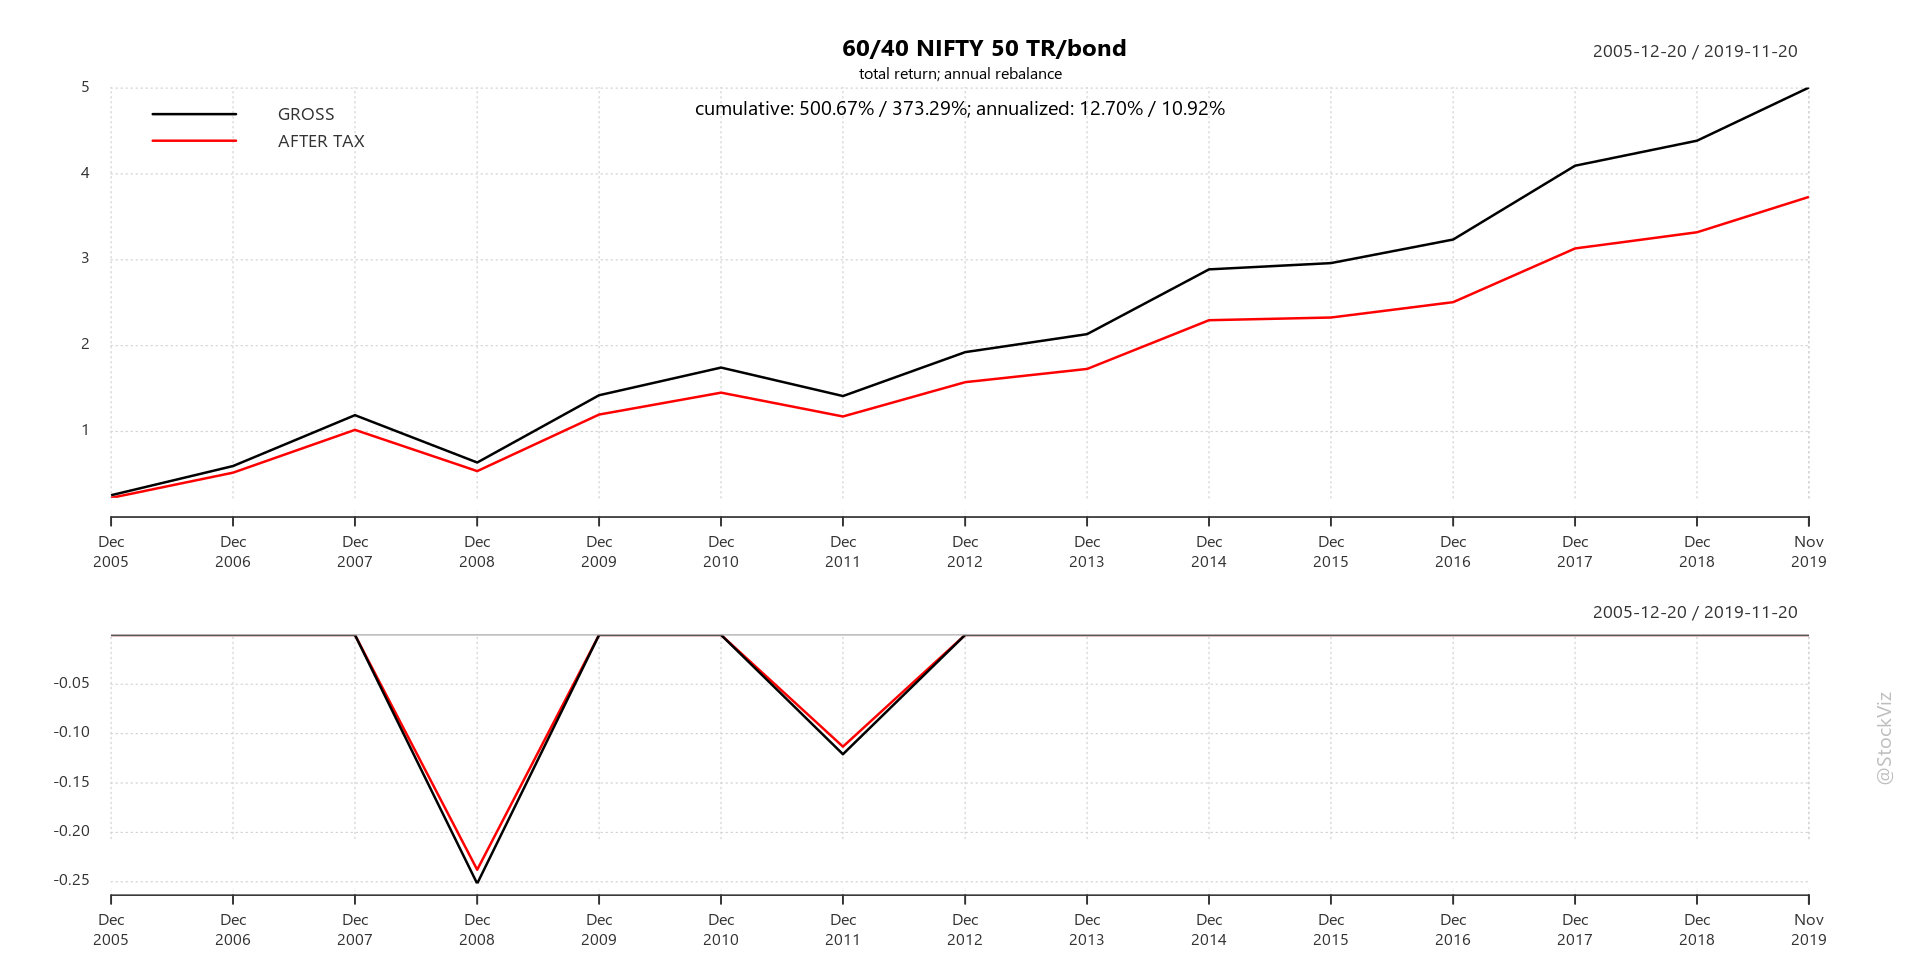

In [34]:
Common.PlotCumReturns(portAnn1Xp, sprintf("60/40 %s/bond", eqIndex1), "total return; annual rebalance")

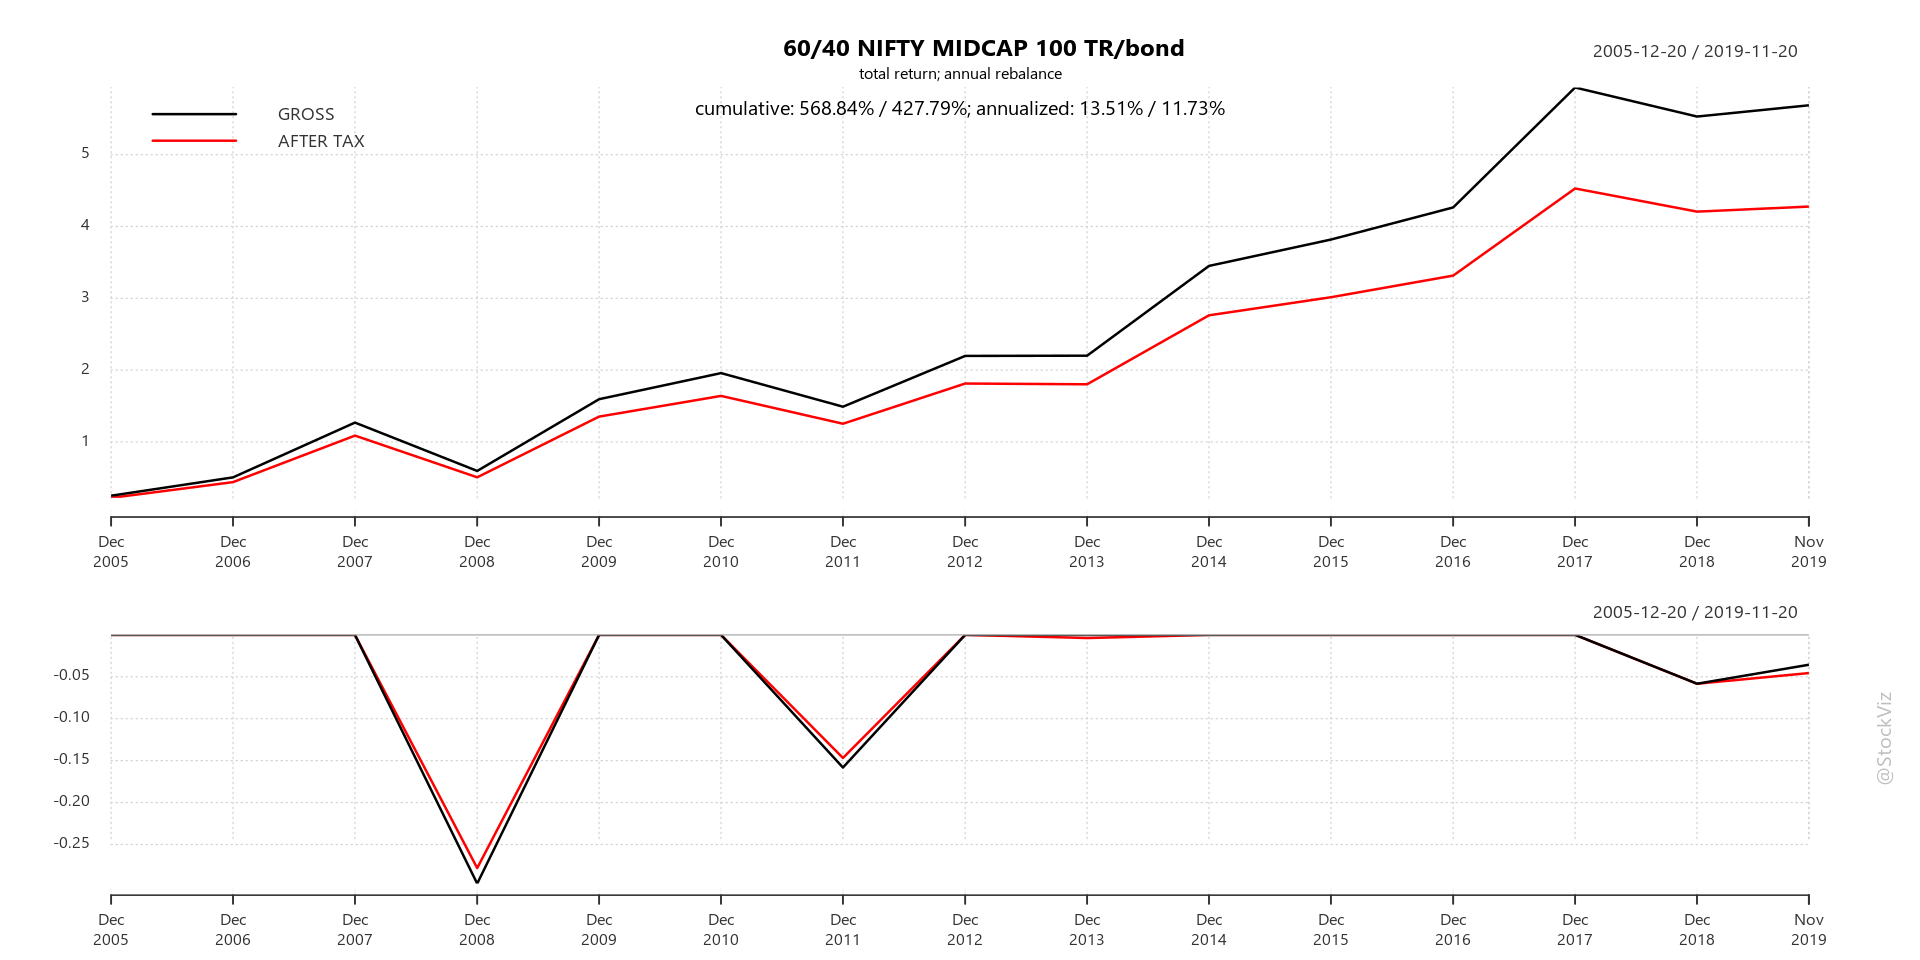

In [35]:
Common.PlotCumReturns(portAnn2Xp, sprintf("60/40 %s/bond", eqIndex2), "total return; annual rebalance")

## 70/30 equity/bond portfolio

In [39]:
portAnn1X <- allXts[,4]*0.7 + allXts[,6]*0.3
portAnn2X <- allXts[,5]*0.7 + allXts[,6]*0.3

### add a equity-oriented balanced fund into the mix

In [45]:
#sc <- 112936 #Reliance Regular Savings Fund - Balanced Option; Nippon India Equity Hybrid Fund - Growth Plan
sc <- 102885 #SBI Magnum Balanced Fund; SBI EQUITY HYBRID FUND

mfi <- MutualFundsIndia()
nav <- mfi$NavTimeSeries() %>%
        filter(SCHEME_CODE == sc) %>%
        select(TIME_STAMP, NAV) %>%
        collect() %>%
        mutate(TIME_STAMP = as.Date(TIME_STAMP))
    
navRet <- Common.NormalizeMonthlyDates(yearlyReturn((xts(nav$NAV, nav$TIME_STAMP))))

In [46]:
portAnn1Xp <- na.omit(merge(portAnn1, portAnn1X, navRet))
portAnn2Xp <- na.omit(merge(portAnn2, portAnn2X, navRet))

names(portAnn1Xp) <- c('GROSS', "AFTER TAX", "FUND")
names(portAnn2Xp) <- c('GROSS', "AFTER TAX", "FUND")

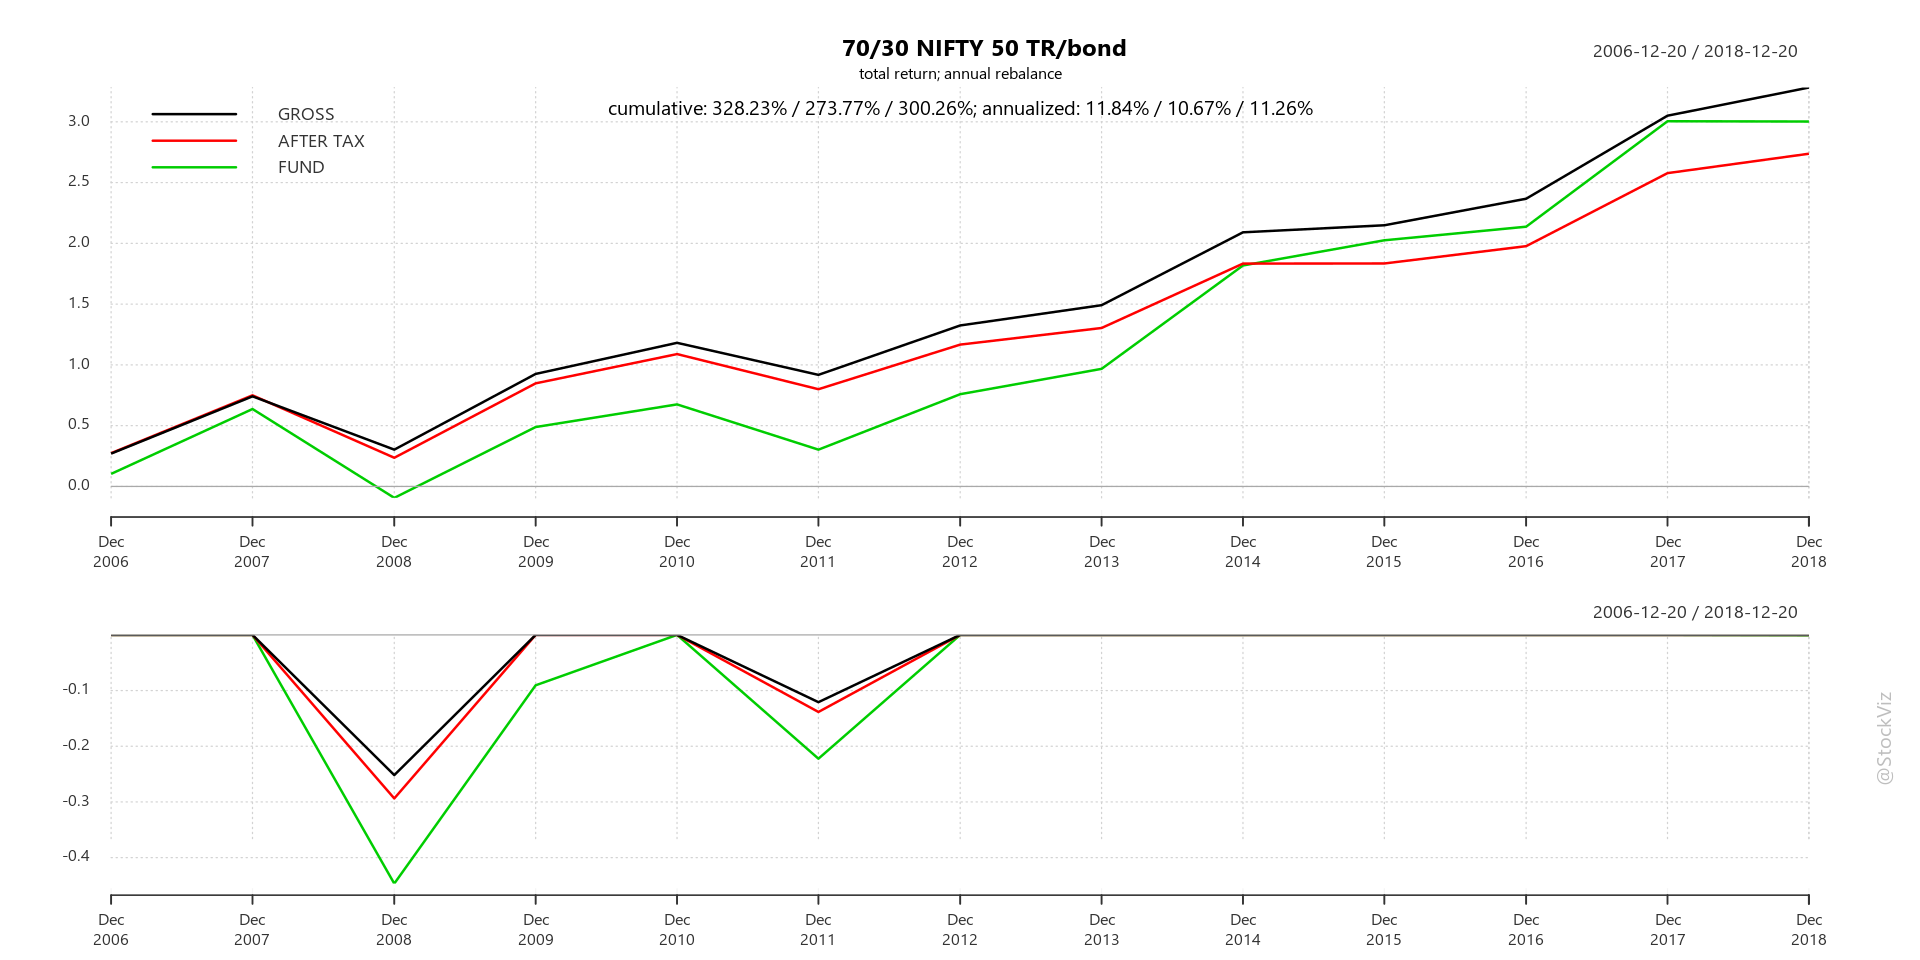

In [47]:
Common.PlotCumReturns(portAnn1Xp, sprintf("70/30 %s/bond", eqIndex1), "total return; annual rebalance")

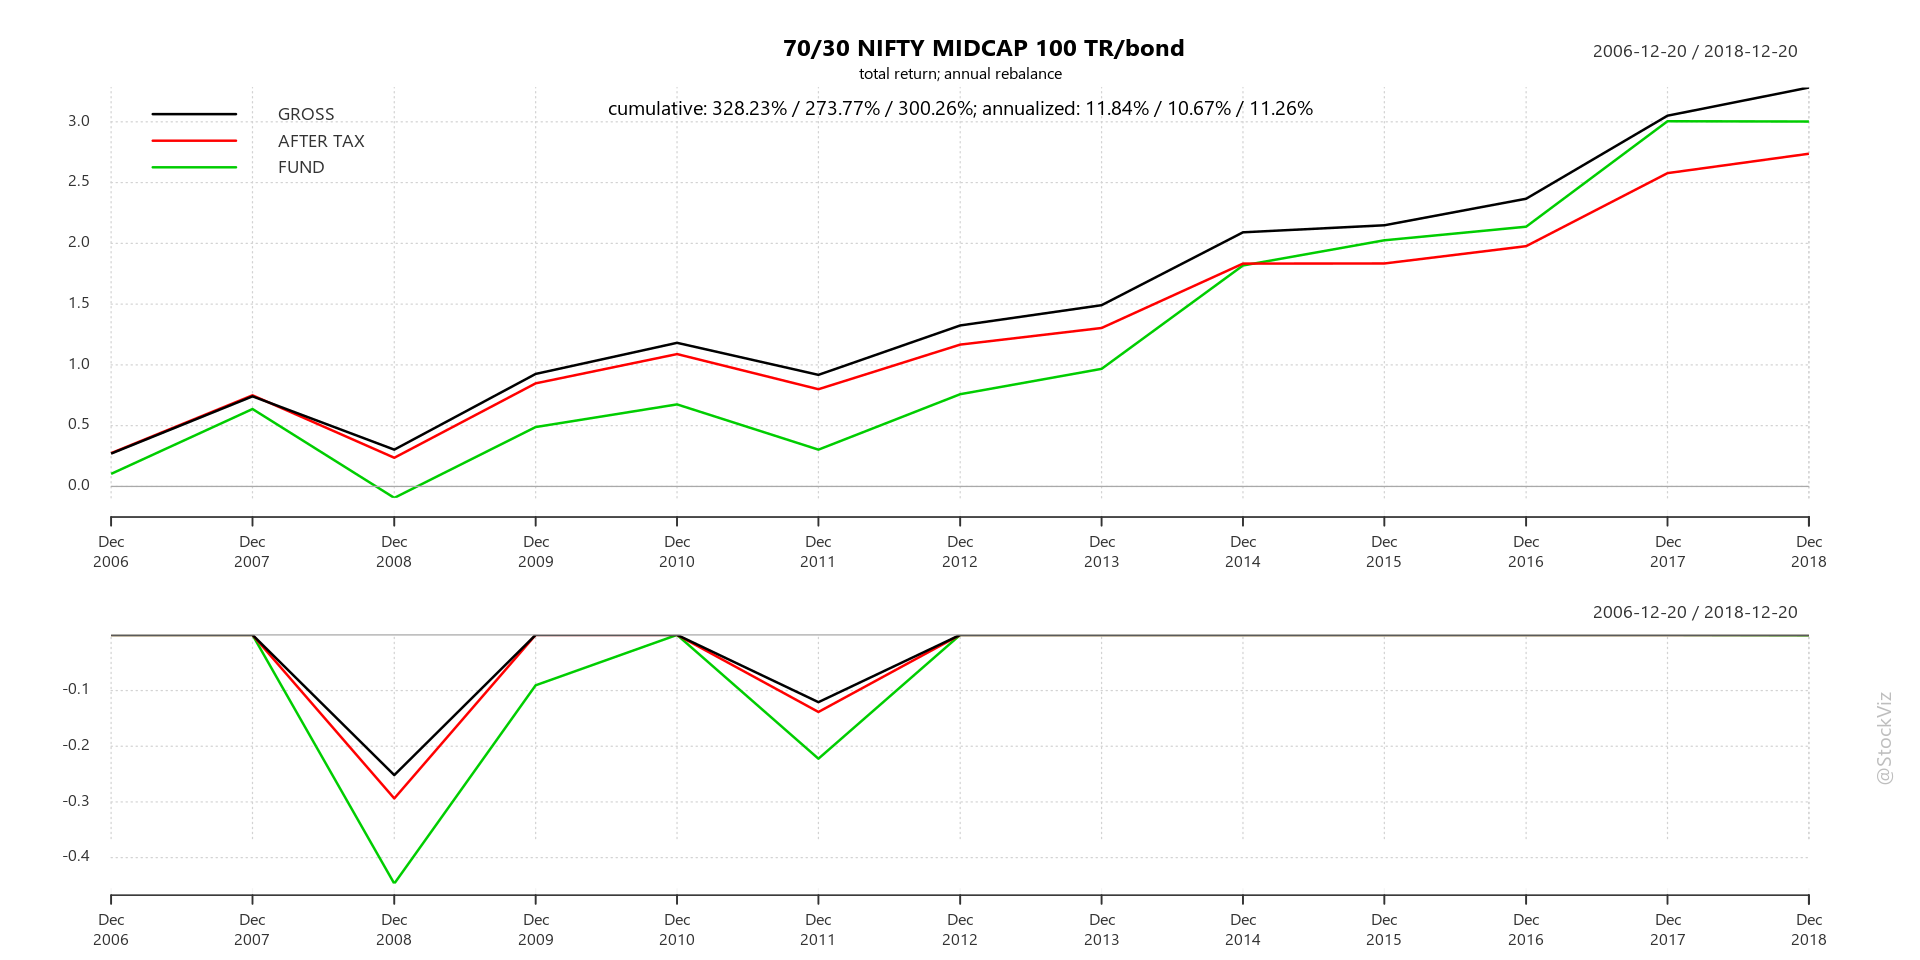

In [48]:
Common.PlotCumReturns(portAnn1Xp, sprintf("70/30 %s/bond", eqIndex2), "total return; annual rebalance")

This notebook was created using [pluto](https://pluto.studio). Thank you for playing fair!